In [37]:
name

'quasi_periodic'

In [38]:
import numpy as np
from numpy import cos, sin, cosh, sinh, tanh, array,pi, exp,array,sqrt
from numpy.linalg import norm,solve
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sdeint
import scipy.linalg
import scipy.io
from model import linearisedSystem,model,eigen,Usolve,Lsolve
import time
from joblib import Parallel,delayed

In [39]:
# Define initial paramters
T = 15
N = 601
t = np.linspace(-T,T,N)
# parametrs
k = 1 # damping coefficient
D = lambda v : k*v #linear damping
h = 1 # potential parameter, need h>0
forcingtype, variance = "filtered-white-noise", 0.5
seednumber = 123456789

f,Aplus, Aminus, xplus, xminus = model(h,k,D)    # the vector field, matrices for linearised systems at equilibria, and equilibria
dt = 2*T/N
Pplus,Pplusinv,Pminus,Pinvminus,lambda2, omega, lambda3, lambda4  =  eigen(h,k)


In [3]:

# Forcing function
# name = 'periodic'
# g = lambda t: np.array([0 ,0 ,0 ,cos(t)])

# name = 'autonomous'
# g = lambda t: np.array([0 ,0 ,0 ,0])


name='quasi_periodic'
g = lambda t: np.array([0,0,0,np.cos(np.sqrt(2)*t)+2*np.cos(4*t)])


Create stochastic forcing
---
This is given by 
$$ \dot{\eta} = \begin{pmatrix}-\lambda & -\omega \\ \omega & -\lambda\end{pmatrix} \eta + B \xi $$

In [40]:
name = 'stochastic'
tspan=np.load(f'data_{name}/tspan.npy')
noise=np.load(f'data_{name}/noise.npy')

dense_noise = scipy.interpolate.CubicSpline(tspan,noise)

g = lambda t : np.matmul(np.array([[0,0],[0,0],[1,0],[0,1]]),dense_noise(t))

In [41]:
def phi(t0,dt,x0):
    F = lambda t,x : f(x,t)+g(t)
    result = scipy.integrate.solve_ivp(F,[t0,t0+dt],x0,method = 'RK45',max_step = dt/3)
    result = result.y
    result = result.T
    return result[-1]

In [42]:
X_hyp_plus = np.load(f'data_{name}/X_hyp_plus.npy')
X_hyp_minus=np.load(f'data_{name}/X_hyp_minus.npy')


## Stable manifold trajectories
---


In [43]:
Deltatminus = int(-np.log(10)/(dt*lambda3))
Deltatplus = int(np.log(10)/(dt*lambda4))
print(Deltatminus)
print(Deltatplus)

28
74


## Now we make the dividing manifold
-----
For this we will need many stable manifold trajectories in order to compute the manifolds. Here we repeat earlier code but for more times

In [7]:
import pickle
M = 5
R = .5
q1,q2,q3 = np.meshgrid(np.linspace(-R,R,M),np.linspace(-R,R,M),np.linspace(-R,R,M))
q1=q1.reshape(-1)
q2=q2.reshape(-1)
q3 = q3.reshape(-1)
Q = np.vstack((q1,q2,q3)).T

Q_plus_t = []
Q_minus_t = []
SM_plus_t = []
SM_minus_t = []
j0 = int((N-1)/2) + 1
# j0 = 368
for j in range(j0-1,N-Deltatplus -1,1):
# for j in [j0-1]:
    start = time.time()
    for sign in [-1,1]:
        if sign == 1:
            A = Aplus
            P = Pplus
            Pinv = Pplusinv
            X_hyp = X_hyp_plus
        elif sign == -1:
            A = Aminus
            P = Pminus
            Pinv = Pinvminus
            X_hyp = X_hyp_minus

        def F_S(X,q,j,imin,M):
            # N number of points taken, X is diplacement from x0
            Y = np.zeros((M,4))
            X = X.reshape((M,4))
            for i in range(0, M-1):
                Y[i] = phi(t[i],dt,X[i]+X_hyp[i+imin]) - X_hyp[i+imin]  - X[i+1]
                # Y[i] = phi(X[i] + x0,t[i]) - X[i+1] - x0   # ensures this is a trajectory.
            # Boundary conditions (stable/unstable coordinates are zero to keep bounded ( need displacement from equilibrium)
            Y[-1][1] = Pinv.dot(X[j-imin])[0] - q[0]
            Y[-1][1] = Pinv.dot(X[j-imin])[1] -q[1]
            Y[-1][2] = Pinv.dot(X[j-imin])[2] - q[2]
            Y[-1][3] = Pinv.dot(X[-1])[3] # unstable
            return Y.reshape(4*M)
        def get_DF0_Ssolve(j,imin,M):
            DF0_S = np.zeros((4*M,4*M))
            Dphi = scipy.linalg.expm(dt*A) # matrix exponential for linear flow displacement from x0

            j = j-imin
            for i in range(0,M-1):
                # find linear derivative
                DF0_S[4*i:4*i + 4, 4*i:4*i + 4] = Dphi
                DF0_S[4*i:4*i +4,4*i+4:4*i+8] = -np.eye(4)
            DF0_S[4*M-4,4*j:4*j+4] = np.dot(Pinv.transpose(),array([1,0,0,0]))
            DF0_S[4*M-3,4*j:4*j+4] = np.dot(Pinv.transpose(),array([0,1,0,0]))
            DF0_S[4*M-2,4*j:4*j+4] = np.dot(Pinv.transpose(),array([0,0,1,0]))
            DF0_S[4*M-1,4*M-4:] = np.dot(Pinv.transpose(),array([0,0,0,1]))
            Permute, L, U = scipy.linalg.lu(DF0_S) # numerical LU decomposition. This is computed once to maximise efficiency
            def DF0_Ssolve(y0):   # we only store the solution function to DF*h = y.
                x0 = np.transpose(Permute).dot(y0)
                return Usolve(Lsolve(x0,L),U)
            return DF0_Ssolve
        def Find_stable_trajectory(q,j,epsF =1e-2,epsC = 1e-2):
        # if __name__ == '__main__':    

            Deltatminus = int(-np.log(10)/(dt*lambda3))
            Deltatplus = int(np.log(10)/(dt*lambda4))
            imin = j -Deltatminus
            imax = j+ Deltatplus
            M = imax -imin + 1
            p_0 = np.matmul(P,np.hstack((q,0)))
            S = np.arange(imin,imax+1,1) - j
            X0 = [np.matmul(scipy.linalg.expm(s*dt*A),p_0) for s in S]
            X0 = np.array(X0)
            X = X0.reshape(-1)
            Fx = F_S(X,q,j,imin,M)
            DF0_Ssolve = get_DF0_Ssolve(j,imin,M)
            delta = DF0_Ssolve(Fx)
            for _ in range(0,100):
                X = X - delta
                Fx = F_S(X,q,j,imin,M)
                delta = DF0_Ssolve(Fx)
                norm_Fx = np.linalg.norm(Fx)
                print(f'F_error = {norm_Fx}, x_error = {np.linalg.norm(delta)}')
                if norm_Fx > 1000 or (norm_Fx < epsF and np.linalg.norm(delta)< epsC):
                    break
            if (norm_Fx < epsF and np.linalg.norm(delta)< epsC):
                X_S = X.reshape((M,4)) + X_hyp[imin:imax+1]
                flag = True
            else:
                X_S = X0
                flag = False
            return X_S[j-imin],flag
        def get_point(q):
            X_S,flag = Find_stable_trajectory(q,j)
            p = X_S
            return p,flag
        SM = []
        # for q in Q:
        #     SM.append(get_point(q)) 
        SM = Parallel(n_jobs=-2)(delayed(get_point)(q) for q in Q)
        P = [p[0] for p in SM]
        flags = [p[1] for p in SM]
        if any(flags):
            Q_ = np.vstack((Q[flags].T,t[j]+np.zeros(len(Q[flags])))).T

            if sign == 1:
                Q_plus = Q_
                SM_plus = np.array(P)
                SM_plus = SM_plus[flags]
            elif sign == -1:
                Q_minus = Q_
                SM_minus = np.array(P)
                SM_minus = SM_minus[flags]

    with open(f'data_{name}/Q_plus_{j}','wb') as fb:
        pickle.dump(Q_plus,fb)
    with open(f'data_{name}/Q_minus_{j}','wb') as fb:
        pickle.dump(Q_minus,fb)
    with open(f'data_{name}/SM_plus_{j}','wb') as fb:
        pickle.dump(SM_plus,fb)
    with open(f'data_{name}/SM_minus_{j}','wb') as fb:
        pickle.dump(SM_minus,fb) 
    elapsed = time.time() - start
    print(f'Elapsed time = {elapsed:.1f}')

Elapsed time = 138.5
Elapsed time = 128.8
Elapsed time = 131.8
Elapsed time = 177.2
Elapsed time = 152.0
Elapsed time = 129.5
Elapsed time = 138.5
Elapsed time = 158.8
Elapsed time = 120.4
Elapsed time = 122.3
Elapsed time = 114.9
Elapsed time = 115.6
Elapsed time = 126.7
Elapsed time = 121.5
Elapsed time = 113.5
Elapsed time = 111.7
Elapsed time = 127.9
Elapsed time = 111.0
Elapsed time = 123.8
Elapsed time = 119.2
Elapsed time = 110.8
Elapsed time = 111.4
Elapsed time = 143.1
Elapsed time = 110.9
Elapsed time = 123.7
Elapsed time = 113.1
Elapsed time = 119.2
Elapsed time = 151.5
Elapsed time = 111.3
Elapsed time = 116.5
Elapsed time = 118.6
Elapsed time = 110.4
Elapsed time = 112.3
Elapsed time = 117.3
Elapsed time = 131.7
Elapsed time = 131.9
Elapsed time = 109.7
Elapsed time = 62.9
Elapsed time = 61.7
Elapsed time = 53.9
Elapsed time = 54.5
Elapsed time = 54.5
Elapsed time = 59.0
Elapsed time = 54.0
Elapsed time = 64.1
Elapsed time = 55.3
Elapsed time = 54.6
Elapsed time = 58.2
Ela

In [44]:
import pickle
import os
Q_plus_t= []
Q_minus_t = []
SM_plus_t = []
SM_minus_t = []
computed_times = []
j0 = int((N-1)/2)
for j in range(j0,N-Deltatplus -1,1):
    if os.path.isfile(f'data_{name}/Q_plus_{j}'):
        computed_times.append(j)
        with open(f'data_{name}/Q_plus_{j}','rb') as fb:
            Q_plus = pickle.load(fb)
        Q_plus_t.append(Q_plus)
    if os.path.isfile(f'data_{name}/SM_plus_{j}'):
        with open(f'data_{name}/SM_plus_{j}','rb') as fb:
            SM_plus = pickle.load(fb)
        SM_plus_t.append(SM_plus)
    if os.path.isfile(f'data_{name}/Q_minus_{j}'):
        with open(f'data_{name}/Q_minus_{j}','rb') as fb:
            Q_minus = pickle.load(fb)
        Q_minus_t.append(Q_minus)
    if os.path.isfile(f'data_{name}/SM_minus_{j}'):
        with open(f'data_{name}/SM_minus_{j}','rb') as fb:
            SM_minus = pickle.load(fb)
        SM_minus_t.append(SM_minus)
print(f'Computed until {max(computed_times)}')

Computed until 525


## Computing dividing manifold
-----
To do this need to compute the derivative of iota

In [45]:
delta_q = 1e-3
o = np.zeros(3)
e1 = np.array([1,0,0])
e2 = np.array([0,1,0])
e3 = np.array([0,0,1])

def make_local_immersion(Q,X,Y,VX,VY):
    x =  scipy.interpolate.Rbf(Q[:,0],Q[:,1],Q[:,2],X)
    y =  scipy.interpolate.Rbf(Q[:,0],Q[:,1],Q[:,2],Y)
    vx =  scipy.interpolate.Rbf(Q[:,0],Q[:,1],Q[:,2],VX)
    vy =  scipy.interpolate.Rbf(Q[:,0],Q[:,1],Q[:,2],VY)
    iota= lambda q: np.array([x(q[0],q[1],q[2]),y(q[0],q[1],q[2]),vx(q[0],q[1],q[2]),vy(q[0],q[1],q[2])])
    Diota = [(iota(o+delta_q*e1) - iota(o))/delta_q,(iota(o+delta_q*e2) - iota(o))/delta_q,(iota(o+delta_q*e3) - iota(o))/delta_q]
    Diota = np.vstack(Diota).T
    return iota, Diota

iota_plus = {}
iota_minus = {}
Diota_plus = np.zeros((len(computed_times),4,3))
Diota_minus =  np.zeros((len(computed_times),4,3))
for i,j in enumerate(computed_times):
    SM = SM_plus_t[i]
    x_plus  = SM[:,0]
    y_plus  = SM[:,1]
    vx_plus  = SM[:,2]
    vy_plus  = SM[:,3]
    t_plus = t[j]
    Q = Q_plus_t[i]
    iota,Diota =  make_local_immersion(Q,x_plus,y_plus,vx_plus,vy_plus)
    iota_plus[j] = iota
    Diota_plus[i] = Diota 
    SM = SM_minus_t[i]
    x_minus  = SM[:,0]
    y_minus  = SM[:,1]
    vx_minus  = SM[:,2]
    vy_minus  = SM[:,3]
    t_minus = t[j]
    Q = Q_minus_t[i]
    iota,Diota =  make_local_immersion(Q,x_minus,y_minus,vx_minus,vy_minus)
    iota_minus[j] = iota
    Diota_minus[i] = Diota


In [46]:

Diota_plus = scipy.interpolate.CubicSpline(t[computed_times],Diota_plus[:,],bc_type='natural',extrapolate=False)
Diota_minus = scipy.interpolate.CubicSpline(t[computed_times],Diota_minus[:,],bc_type='natural',extrapolate=False)

In [47]:
X_hyp_plus = scipy.interpolate.CubicSpline(t,X_hyp_plus,bc_type='natural',extrapolate=True)
X_hyp_minus = scipy.interpolate.CubicSpline(t,X_hyp_minus,bc_type='natural',extrapolate=True)


In [48]:
def D_plus(t0,p):
    A = np.vstack((Diota_plus(t0).dot(e1),Diota_plus(t0).dot(e2),Diota_plus(t0).dot(e3) + Pplus[3,:])).T
    DividingPlane = scipy.linalg.orth(A)
    normal = Pplus[3,:]
    normal = normal - np.einsum( 'ij,i,kj->k' , DividingPlane,normal,DividingPlane)
    normal = normal/np.linalg.norm(normal)
    p = p -X_hyp_plus(t0)
    return np.dot(p,normal)
def D_minus(t0,p):
    A = np.vstack((Diota_minus(t0).dot(e1),Diota_minus(t0).dot(e2),Diota_minus(t0).dot(e3) + Pminus[3,:])).T
    DividingPlane = scipy.linalg.orth(A)
    normal = Pminus[3,:]
    normal = normal - np.einsum( 'ij,i,kj->k' , DividingPlane,normal,DividingPlane)
    normal = normal/np.linalg.norm(normal)
    p = p -X_hyp_minus(t0)
    return np.dot(p,normal)


## Numerical experiments
----
Things to do here: Time to capsize classification

In [49]:
SM_plus = np.load(f'data_{name}/SM_plus.npy')
SM_minus = np.load(f'data_{name}/SM_minus.npy')
Q = np.load(f'data_{name}/Q.npy')
flags_plus = np.load(f'data_{name}/flags_plus.npy')
flags_minus = np.load(f'data_{name}/flags_minus.npy')
v_y_plus  = scipy.interpolate.Rbf(SM_plus[flags_plus,0],SM_plus[flags_plus,1],SM_plus[flags_plus,2],SM_plus[flags_plus,3])
v_y_minus  = scipy.interpolate.Rbf(SM_minus[flags_minus,0],SM_minus[flags_minus,1],SM_minus[flags_minus,2],SM_minus[flags_minus,3])


In [50]:
def Time_to_capsize(y0):
    if (D_plus(0,y0) >0 and y0[3]>v_y_plus(y0[0],y0[1],y0[2]))  or  (D_minus(0,y0) >0 and y0[3]<v_y_minus(y0[0],y0[1],y0[2])):
        return 0.
    def event_plus(t,y):
        return D_plus(t,y)
    event_plus.terminal = True
    def event_minus(t,y):
        return D_minus(t,y)
    event_minus.terminal = True
    F = lambda t,x : f(x,t)+g(t)
    if y0[3]>=v_y_plus(y0[0],y0[1],y0[2]):
        event = event_plus
    elif y0[3]<=v_y_minus(y0[0],y0[1],y0[2]):
        event = event_minus
    else:
        return np.inf
    res = solve_ivp (F, [0,np.max(t[computed_times])], y0 , method = "RK45" , events=[event],  max_step =0.001 , rtol = 1e-12 )
    result = res.y
    time= res.t
    result = result.T
    return time[-1]

In [14]:


def is_not_capsize(y0):
    def event(t,y):
        return y[1]**2 - 25
    event.terminal = True
    F = lambda t,x : f(x,t)+g(t)
    res = solve_ivp (F, [0,T], y0 , method = "RK45" , events=[event],  max_step =0.001 , rtol = 1e-15 )
    result = res.y
    result = result.T
    y = result[-1]
    return y[1]**2 < 24


In [51]:


def is_not_capsize(y0):
    return y0[3]< v_y_plus(y0[0],y0[1],y0[2]) and  y0[3]> v_y_minus(y0[0],y0[1],y0[2]) 


ValueError: 'c' argument has 5000 elements, which is inconsistent with 'x' and 'y' with size 3121.

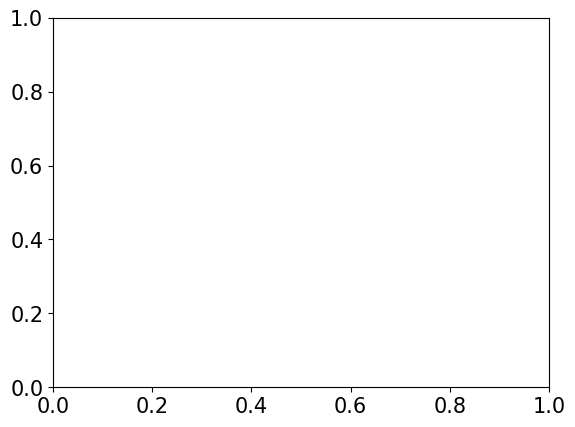

In [53]:
points = np.random.rand(5000,4)
scale = np.array([[2, 0, 0,0],[0,2,0,0],[0,0,10,0],[0,0,0,10]])
points = np.matmul(scale,points.T-.5).T
points[:,2] = 0*points[:,2] 
M=20
R = 1
X = np.linspace(-R,R,M)
plt.rc('font', size=15)          # controls default text sizes

for y_val in [-0.5,,0,0.5]:
    VY_plus = v_y_plus(X,0*X+y_val,0*X)
    VY_minus = v_y_minus(X,0*X+y_val,0*X)
    capsize_times = []
    points[:,1] = 0*points[:,1] +y_val
    safe_flags = Parallel(n_jobs=-2)(delayed(is_not_capsize)(y0) for y0 in points)
    capsize_flags = ~np.array(safe_flags)
    for i,p in enumerate(points):
        if capsize_flags[i] or True:
            capsize_times.append(Time_to_capsize(p))
    points = np.array(points)
    capsize_points = points[capsize_flags,:]
    # np.save(f'data_{name}/capsize_points_y{y_val}_manifolds.npy',capsize_points)
    safe_points=  points[~capsize_flags,:]
    # capsize_points = points[~manifold_flags,:]
    # safe_points=  points[manifold_flags,:]
    # capsize_times=2*np.random.randn(len(capsize_points))
    fig = plt.figure()

    plt.scatter(capsize_points[:,0],capsize_points[:,3],c=capsize_times,cmap='viridis',marker='o',label='Capsize',alpha=0.5)
    plt.colorbar(orientation='horizontal')
    # plt.scatter(safe_points[:,0],safe_points[:,3],color='g',marker='x',alpha = 0.4,label='Safe')
    plt.title(f'y = {y_val}')
    plt.plot(X,VY_plus,color = 'b',label='Stable manifolds')
    plt.plot(X,VY_minus,color = 'b')
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.tight_layout()
    # plt.savefig(f'data_{name}/scatter_{name}_y_{y_val}_time_manifolds.png')

    plt.show()
